Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - kl: 5.1623 - loss: 188.2678 - recon: 183.1054 - val_kl: 4.7516 - val_loss: 167.9186 - val_recon: 163.1670
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - kl: 4.8493 - loss: 164.9609 - recon: 160.1117 - val_kl: 5.3056 - val_loss: 161.3031 - val_recon: 155.9975
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - kl: 5.3075 - loss: 159.1530 - recon: 153.8455 - val_kl: 5.2209 - val_loss: 156.1549 - val_recon: 150.9340
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - kl: 5.5730 - loss: 155.3968 - recon: 149.8239 - val_kl: 5.8877 - val_loss: 153.3407 - val_recon: 147.4530
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - kl: 5.7714 - loss: 153.0106 - recon: 147.2393 - val_kl: 6.0296 - val_loss: 151.4981 - val_recon: 145.4685
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - kl: 5.8986 - loss: 151.0129 - recon: 145.1143 - val_kl: 5.9919 - val_loss: 149.2540 - val_recon: 143.2621
Epoch 7/20
422/422 ━━━━━━━━━━━━━━

c:\Users\eduse\anaconda3\conda\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


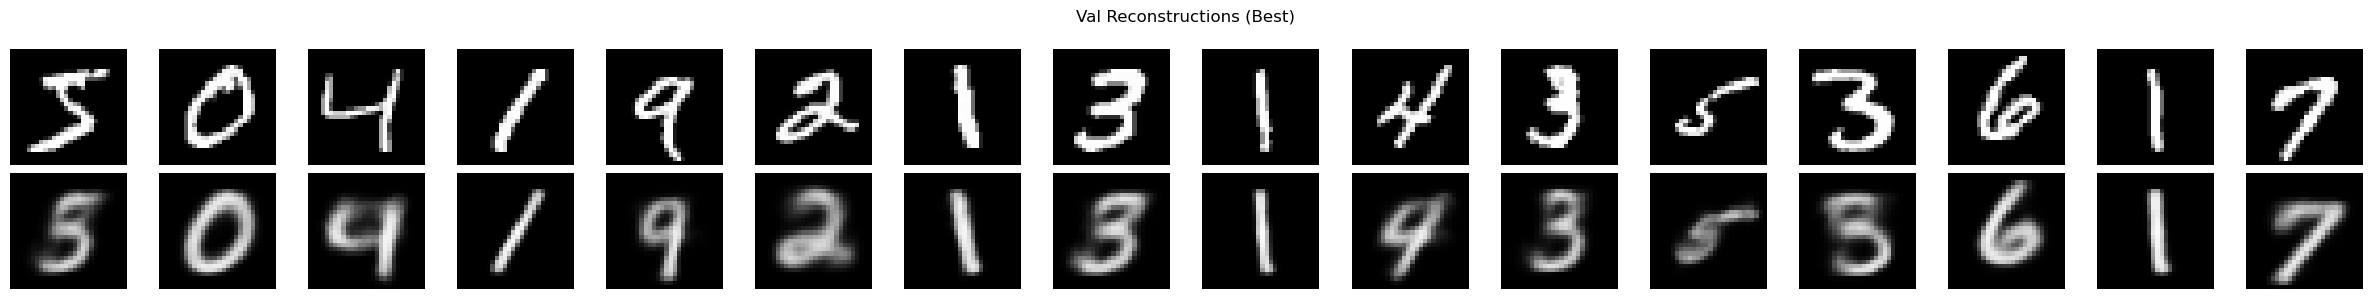

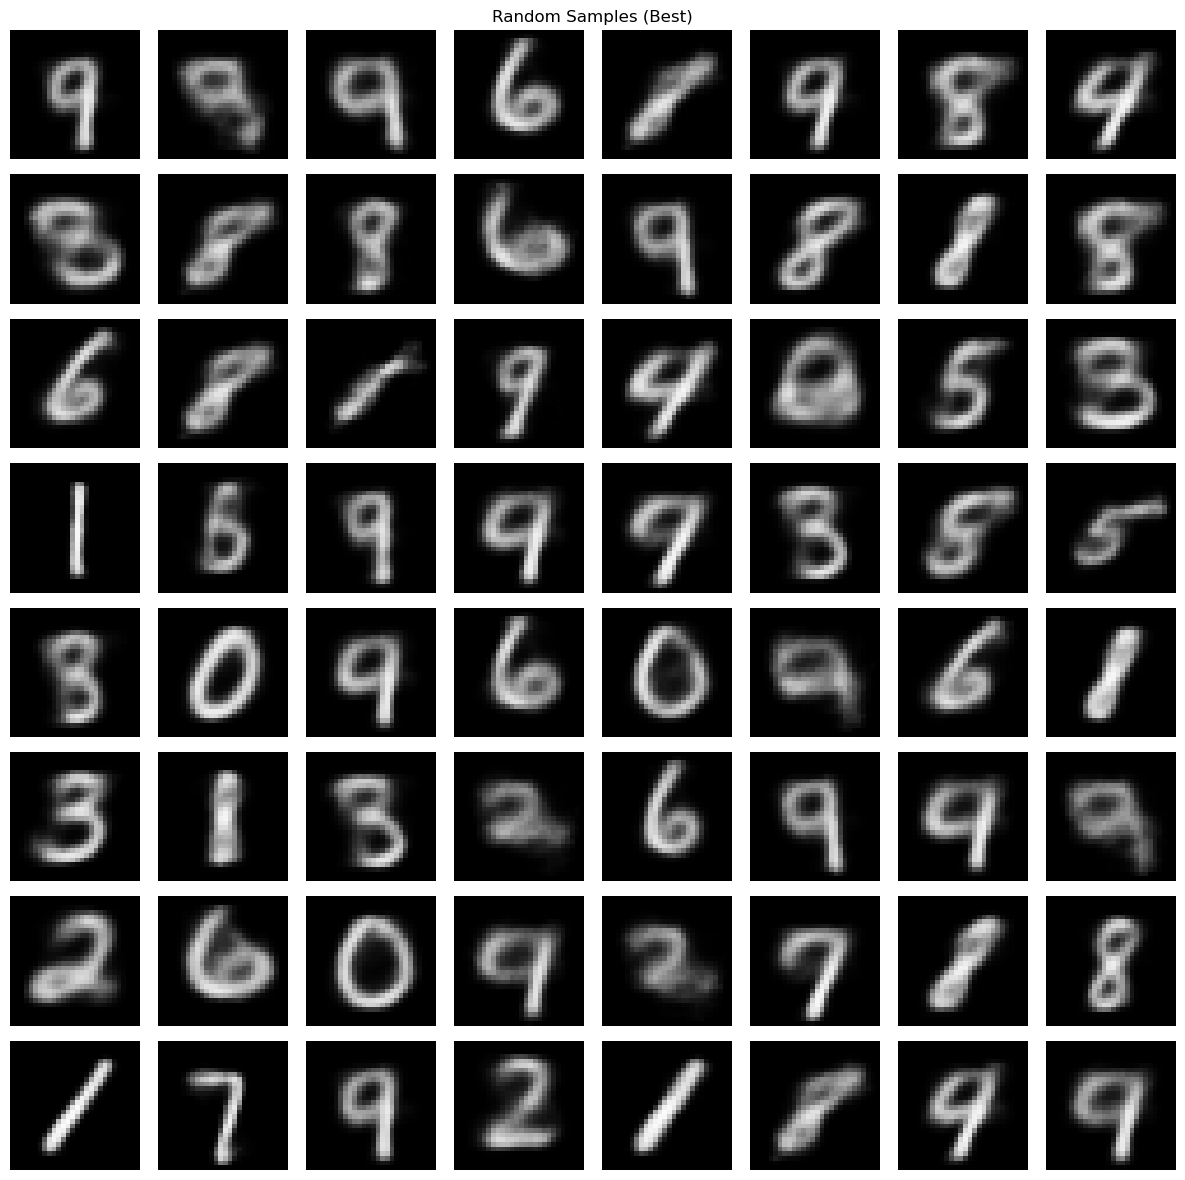

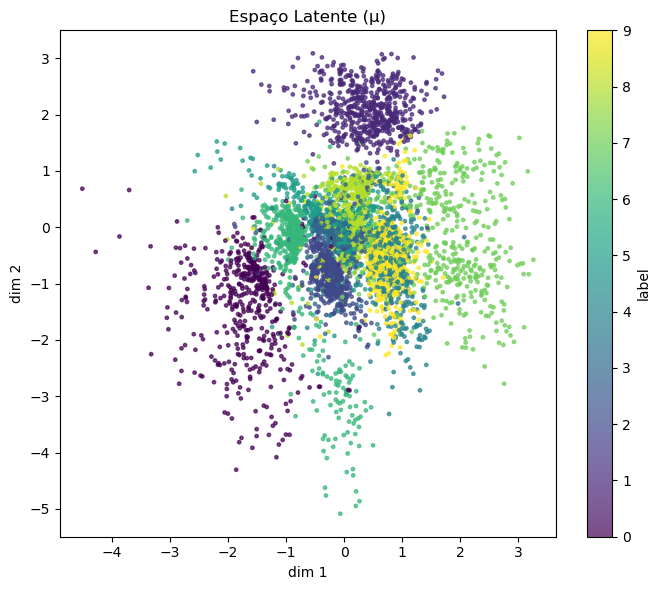

Treino finalizado. Pesos do melhor modelo salvos em 'vae_best_tf.weights.h5'.


In [ ]:

import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


SEED         = 42
DATASET      = "MNIST"     
BATCH_SIZE   = 128
LR           = 1e-3
EPOCHS       = 20
LATENT_DIM   = 2
HIDDEN_DIMS  = [512, 256]
VAL_SPLIT    = 0.1
SAMPLES_N    = 64
INPUT_SHAPE  = (28, 28, 1)
INPUT_DIM    = 28 * 28


random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


def load_dataset(name="MNIST"):
   
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
   
    x_train = (x_train.astype("float32") / 255.0)[..., None]
    x_test  = (x_test.astype("float32")  / 255.0)[..., None]
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_dataset(DATASET)

n_total = x_train.shape[0]
n_val = int(n_total * VAL_SPLIT)
x_val, y_val = x_train[:n_val], y_train[:n_val]
x_train, y_train = x_train[n_val:], y_train[n_val:]

def make_ds(x, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(x), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(x_train, y_train, shuffle=True)
val_ds   = make_ds(x_val, y_val, shuffle=False)
test_ds  = make_ds(x_test, y_test, shuffle=False)


class Encoder(keras.Model):
    def __init__(self, hidden_dims=HIDDEN_DIMS, latent_dim=LATENT_DIM):
        super().__init__()
        self.flatten = layers.Flatten()
        mlp = []
        dims = [INPUT_DIM] + hidden_dims
        for i in range(len(dims) - 1):
            mlp += [layers.Dense(dims[i + 1], activation="relu")]
        self.mlp = keras.Sequential(mlp)
        self.mu = layers.Dense(latent_dim)
        self.logvar = layers.Dense(latent_dim)

    def call(self, x, training=False):
        x = self.flatten(x)
        h = self.mlp(x, training=training)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar


class Decoder(keras.Model):
    def __init__(self, hidden_dims=HIDDEN_DIMS, latent_dim=LATENT_DIM, output_dim=INPUT_DIM):
        super().__init__()
        mlp = []
        dims = [latent_dim] + hidden_dims[::-1]
        for i in range(len(dims) - 1):
            mlp += [layers.Dense(dims[i + 1], activation="relu")]
        mlp += [layers.Dense(output_dim, activation="sigmoid")]
        self.mlp = keras.Sequential(mlp)
        self.reshape = layers.Reshape(INPUT_SHAPE)

    def call(self, z, training=False):
        x_hat_flat = self.mlp(z, training=training)
        x_hat = self.reshape(x_hat_flat)
        return x_hat


class VAE(keras.Model):
    def __init__(self, hidden_dims=HIDDEN_DIMS, latent_dim=LATENT_DIM):
        super().__init__()
        self.encoder = Encoder(hidden_dims, latent_dim)
        self.decoder = Decoder(hidden_dims, latent_dim)
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon")
        self.kl_loss_tracker    = keras.metrics.Mean(name="kl")

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=tf.shape(mu))
        std = tf.exp(0.5 * logvar)
        return mu + std * eps

    def compute_loss(self, x, training=False):
        mu, logvar = self.encoder(x, training=training)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z, training=training)

        
        bce_per_pixel = keras.losses.binary_crossentropy(x, x_hat)
        bce_per_sample = tf.reduce_sum(bce_per_pixel, axis=[1, 2])
        recon_loss = tf.reduce_mean(bce_per_sample)

        kl_per_sample = -0.5 * tf.reduce_sum(
            1.0 + logvar - tf.square(mu) - tf.exp(logvar), axis=1
        )
        kl_loss = tf.reduce_mean(kl_per_sample)

        total = recon_loss + kl_loss
        return total, recon_loss, kl_loss, x_hat, mu, logvar, z

    
    def call(self, x, training=False):
        mu, logvar = self.encoder(x, training=training)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z, training=training)
        return x_hat

    def train_step(self, data):
        x, _ = data
        with tf.GradientTape() as tape:
            total, recon, kl, _, _, _, _ = self.compute_loss(x, training=True)
        grads = tape.gradient(total, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon": self.recon_loss_tracker.result(),
                "kl": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x, _ = data
        total, recon, kl, _, _, _, _ = self.compute_loss(x, training=False)
        self.total_loss_tracker.update_state(total)
        self.recon_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(),
                "recon": self.recon_loss_tracker.result(),
                "kl": self.kl_loss_tracker.result()}


vae = VAE()
optimizer = keras.optimizers.Adam(LR)
vae.compile(optimizer=optimizer)


_ = vae(tf.zeros((1, *INPUT_SHAPE))) 


ckpt_path = "vae_best_tf.weights.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    ckpt_path, monitor="val_loss", save_best_only=True, save_weights_only=True
)

history = vae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb],
    verbose=1,
)


best_vae = VAE()
best_vae.compile(optimizer=keras.optimizers.Adam(LR))
_ = best_vae(tf.zeros((1, *INPUT_SHAPE)))  
best_vae.load_weights(ckpt_path)


def plot_reconstructions(model, dataset, max_images=16, title="Reconstruções"):
    x_batch, _ = next(iter(dataset))
    x = x_batch[:max_images]
    mu, logvar = model.encoder(x, training=False)
    z = model.reparameterize(mu, logvar)
    x_hat = model.decoder(z, training=False)
    x = x.numpy()
    x_hat = x_hat.numpy()
    fig, axes = plt.subplots(2, max_images, figsize=(1.5*max_images, 3))
    for i in range(max_images):
        axes[0, i].imshow(x[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        axes[0, i].axis("off")
        axes[1, i].imshow(x_hat[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        axes[1, i].axis("off")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_random_samples(model, n=SAMPLES_N, title="Random Samples"):
    z = tf.random.normal(shape=(n, LATENT_DIM))
    x_hat = model.decoder(z, training=False).numpy()
    cols = int(math.sqrt(n))
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    axes = np.array(axes).reshape(rows, cols)
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx < n:
                axes[r, c].imshow(x_hat[idx].squeeze(), cmap="gray", vmin=0, vmax=1)
            axes[r, c].axis("off")
            idx += 1
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_latent_space(model, dataset, max_points=5000):
    mus, ys, seen = [], [], 0
    for x_batch, y_batch in dataset:
        mu, _ = model.encoder(x_batch, training=False)
        mus.append(mu.numpy())
        ys.append(y_batch.numpy())
        seen += x_batch.shape[0]
        if seen >= max_points:
            break
    Z = np.concatenate(mus)[:max_points]
    Y = np.concatenate(ys)[:max_points]
    if Z.shape[1] >= 2:
        plt.figure(figsize=(7, 6))
        plt.scatter(Z[:, 0], Z[:, 1], c=Y, s=6, alpha=0.7)
        plt.colorbar(label="label")
        plt.title("Espaço Latente (μ)")
        plt.xlabel("dim 1"); plt.ylabel("dim 2")
        plt.tight_layout()
        plt.show()
    else:
        print("Latent dimension < 2; pulando latent scatter.")


plot_reconstructions(best_vae, val_ds, max_images=16, title="Val Reconstructions (Best)")
plot_random_samples(best_vae, n=SAMPLES_N, title="Random Samples (Best)")
plot_latent_space(best_vae, test_ds, max_points=5000)

print(f"Treino finalizado. Pesos do melhor modelo salvos em '{ckpt_path}'.")
